In [66]:
import pandas as pd
import numpy as np
import pickle
import sys
import os
import io
import re
from sys import path
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from string import punctuation, digits
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [67]:
#Amazon Data
input_file = "amazon_cells_labelled.txt"
amazon = pd.read_csv(input_file,delimiter='\t',header=None)
amazon.columns = ['Sentence','Class']

#Yelp Data
input_file = "yelp_labelled.txt"
yelp = pd.read_csv(input_file,delimiter='\t',header=None)
yelp.columns = ['Sentence','Class']

#Imdb Data
input_file = "imdb_labelled.txt"
imdb = pd.read_csv(input_file,delimiter='\t',header=None)
imdb.columns = ['Sentence','Class']

In [68]:
data = pd.DataFrame()
data = pd.concat([amazon, yelp, imdb])
data['index'] = data.index
data.head(10)

,Sentence,Class,index
0,So there is no way for me to plug it in here i...,0,0
1,"Good case, Excellent value.",1,1
2,Great for the jawbone.,1,2
3,Tied to charger for conversations lasting more...,0,3
4,The mic is great.,1,4
5,I have to jiggle the plug to get it to line up...,0,5
6,If you have several dozen or several hundred c...,0,6
7,If you are Razr owner...you must have this!,1,7
8,"Needless to say, I wasted my money.",0,8
9,What a waste of money and time!.,0,9


In [69]:
from nltk.text import Text
import nltk.corpus  
f=open('amazon_cells_labelled.txt','rU')
raw=f.read()
tokens = nltk.word_tokenize(raw)
text = nltk.Text(tokens)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
#text.concordance('good')

   Class  COUNT
0      0    846
1      1    827


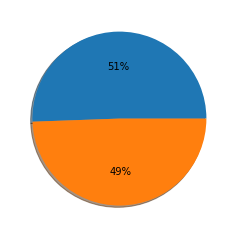

In [71]:
#Total Count of Each Category
pd.set_option('display.width', 4000)
pd.set_option('display.max_rows', 1000)
distOfDetails = data.groupby(by='Class', as_index=False).agg({'index': pd.Series.nunique}).sort_values(by='index', 
                                                                                                       ascending=False)
distOfDetails.columns =['Class', 'COUNT']
print(distOfDetails)
#Distribution of All Categories
plt.pie(distOfDetails['COUNT'],autopct='%1.0f%%',shadow=True, startangle=360)
plt.show()

In [72]:
#Text Preprocessing
columns = ['index','Class', 'Sentence']
df_ = pd.DataFrame(columns=columns)
#lower string
data['Sentence'] = data['Sentence'].str.lower()
#remove email adress
data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
#remove IP address
data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
#remove punctaitions and special chracters
data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')
#remove numbers
data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)
#remove stop words
for index, row in data.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class":  row['Class'],"Sentence": " ".join(filtered_sentence[0:])}, ignore_index=True)
data = df_

In [79]:
#data

In [73]:

X_train, X_test, y_train, y_test = train_test_split(data['Sentence'].values.astype('U'),data['Class'].values.astype('int32'), test_size=0.10, random_state=0)
classes  = data['Class'].unique()

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#grid search result
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2), max_features=50000,max_df=0.5,use_idf=True, norm='l2') 
counts = vectorizer.fit_transform(X_train)
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet')
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
predictions = classifier.predict(example_counts)

E:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [75]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
#Model Evaluation
acc = accuracy_score(y_test, predictions, normalize=True)
hit = precision_score(y_test, predictions, average=None,labels=classes)
capture = recall_score(y_test, predictions, average=None,labels=classes)
print('Model Accuracy:%.2f'%acc)
print(classification_report(y_test, predictions))

Model Accuracy:0.79
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       139
           1       0.79      0.78      0.79       136

   micro avg       0.79      0.79      0.79       275
   macro avg       0.79      0.79      0.79       275
weighted avg       0.79      0.79      0.79       275



,Category,Index
0,0,1
1,1,2


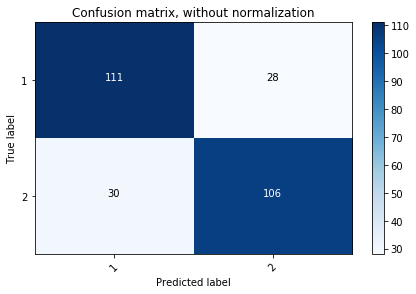

<Figure size 10800x7200 with 0 Axes>

In [76]:

#source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(150,100))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions,classes)
np.set_printoptions(precision=2)
class_names = range(1,classes.size+1)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
classInfo = pd.DataFrame(data=[])
for i in range(0,classes.size):
    classInfo = classInfo.append([[classes[i],i+1]],ignore_index=True)
classInfo.columns=['Category','Index']
classInfo

In [81]:
#vectorizer.vocabulary_